## Develop,Evaluavate,Serve MNIST dense

In [1]:
import tensorflow as tf
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
p = Path('./datasets/MNIST_data/') 
train_images_path = p / 'train-images.idx3-ubyte'
train_label_path = p / 'train-labels.idx1-ubyte'
test_images_path = p / 't10k-images.idx3-ubyte'
test_label_path = p / 't10k-labels.idx1-ubyte'

### 1) Check train image file

> First 16 bytes contain 4 int32 numbers having meta info. Remaining are int8 pixel data with 1 byte each

In [3]:
ft = train_images_path.open('rb')
m,n,h,w = np.frombuffer(ft.read(4*4),np.dtype('u4').newbyteorder('>'))
m,n,h,w

(2051, 60000, 28, 28)

In [4]:
o_im = np.frombuffer(ft.read(),np.dtype('u1')).reshape(n,h,w)
o_im.shape

(60000, 28, 28)

In [5]:
Image.fromarray(o_im[0])

**Check train label file**

> First 8 bytes contain 2 int32 numbers having meta info. Remaining are int8 label data 1 byte each

In [6]:
ft = train_label_path.open('rb')
m,n = np.frombuffer(ft.read(2*4),np.dtype('u4').newbyteorder('>'))
m,n

(2049, 60000)

In [7]:
o = np.frombuffer(ft.read(),np.dtype('u1'))
o.shape

(60000,)

In [8]:
o[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

### 2) Create read pipeline

> Create separate training and test dataset pipeline. Use **Reinitializable** iterator to switch between them. This type of iterators are useful when we want to fine tune the model on different dataset with different preprocessing pipeline

> Make it possible not to depend on iterators for serving

In [9]:
def mnist_dataset(train:bool) -> tf.data.Dataset:
    if train:
        #4 byte offset for 4 numbers
        im = tf.data.FixedLengthRecordDataset([str(train_images_path)],28*28,header_bytes=16)
        #4 byte offset for 2 numbers
        label = tf.data.FixedLengthRecordDataset([str(train_label_path)],1,header_bytes=8)        
    else:
        im = tf.data.FixedLengthRecordDataset([str(test_images_path)],28*28,header_bytes=16)
        label = tf.data.FixedLengthRecordDataset([str(test_label_path)],1,header_bytes=8)
        
    im = im.map(lambda x: tf.decode_raw(x,tf.uint8),num_parallel_calls=4)
    im = im.map(lambda x: tf.reshape(x,(28,28,1)),num_parallel_calls=4) 
    im = im.map(lambda x: tf.image.convert_image_dtype(x,tf.float32),num_parallel_calls=4)  
    
    label = label.map(lambda x: tf.decode_raw(x,tf.uint8), num_parallel_calls=4)
    label = label.map(lambda x: tf.one_hot(x,10), num_parallel_calls=4)
    
    dataset = tf.data.Dataset.zip((im,label))
        
    return dataset

**Training dataset**

In [10]:
with tf.device('/cpu:0'):
    train_dataset = mnist_dataset(True)
    train_dataset = train_dataset.shuffle(20000)
    train_dataset = train_dataset.repeat(10)
    train_dataset = train_dataset.batch(10)
    train_dataset = train_dataset.prefetch(2)

In [11]:
train_dataset.output_types,train_dataset.output_shapes

((tf.float32, tf.float32),
 (TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(None), Dimension(10)])))

**Test dataset**

In [12]:
with tf.device('/cpu:0'):
    test_dataset = mnist_dataset(False)
    test_dataset = test_dataset.batch(10)
    test_dataset = test_dataset.prefetch(2)

In [13]:
test_dataset.output_types,test_dataset.output_shapes

((tf.float32, tf.float32),
 (TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(None), Dimension(10)])))

While creating reinitializable iterator, the output shapes and types of dataset shpuld match

In [14]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,train_dataset.output_shapes)
im,label = iterator.get_next()

In [15]:
training_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

**Production** : In this case, dont use iterator (The **if condition** however increases training time by a minor fraction)

In [16]:
is_serving = tf.placeholder_with_default(tf.constant(False),[])
#Do not use tf.int32 or int64 images! This scales float values close to 0
serving_input = tf.placeholder_with_default(np.zeros((1,28,28,1),dtype=np.uint8),(None,28,28,1))
serving_input_float = tf.image.convert_image_dtype(serving_input,tf.float32,saturate=True)

**Model input**

In [17]:
#Using this if cond increases total training(60Kx10 images) time by 2s
model_input = tf.cond(is_serving,lambda:serving_input_float,lambda:im)

In [18]:
with tf.Session() as sess:
    sess.run(test_init_op)
    i,l = sess.run([model_input,label])

**Check**

In [19]:
i.shape

(10, 28, 28, 1)

In [20]:
l.shape

(10, 1, 10)

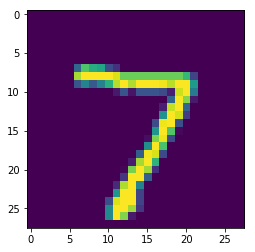

In [21]:
plt.imshow(i[0].reshape(28,28))

**It is a float image**

In [22]:
i[0].min(),i[0].max()

(0.0, 1.0)

**Check label**

In [23]:
print(np.where(l[0][0]==1))

(array([7]),)


In [24]:
l

array([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], dtype=float32)

**Check serving**

In [25]:
Image.open('pics/img_13.jpg')

Although we dont use iterators, error was thrown when one of them were not initialized

In [26]:
test_im1 = np.asarray(Image.open('pics/img_13.jpg')).reshape(1,28,28,1)
test_im2 = np.asarray(Image.open('pics/img_24.jpg')).reshape(1,28,28,1)
test_ims = np.concatenate((test_im1,test_im2),axis=0) #(2,28,28,1)
print(test_ims.shape)

with tf.Session() as sess:
    sess.run(test_init_op) #Throws error when one of the iterators are not initialized
    it = sess.run(model_input,{is_serving:True,serving_input:test_ims})

(2, 28, 28, 1)


In [27]:
it[0].min(), it[0].max(), it.shape

(0.0, 1.0, (2, 28, 28, 1))

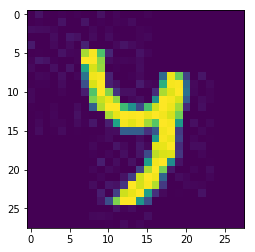

In [28]:
plt.imshow(it[0].reshape(28,28))

### 3) Create Model

**tf.layers.dense()**

> **units** : Number of output units

> **activation**: (Default:No activation) Eg, tf.nn.relu  (No brackets in the end)

> **kernel_initializer**: (Default:glorot_uniform). Initializer for **W** Eg. tf.initializers.glorot_normal() (Need brackets in the end)

> **bias_initializer** : (Default: zeros) Initializer for **b**

> **kernel_regularizer** : (Default:None) Regularizer for **W**. Reg term should be manually added to the final loss

> **bias_regularizer** : (Default:None) Regularizer for **b**. Eg. tf.contrib.layers.l2_regularizer(scale=0.01)

> **activity regularizer**: (Default:None) Allows regularizer of the output from the layer to be computed.  

>> Adding regularization to the loss,
```bash
l2_loss = tf.losses.get_regularization_loss()
....
loss += l2_loss
```

> **kernel/bias constraint** : TODO

In [31]:
def dense_model(model_input):
    
    x = tf.reshape(model_input,(-1,784)) 
    #x = tf.layers.Flatten()(model_input) #Flattens input preserving batch axis (axis 0)
    #x = tf.reshape(model_input,(tf.shape(model_input)[0],784)) # use tf.shape(tensor)[0] instead of tensor.shape[0]
    
    h1 = tf.layers.dense(x,300, 
                         activation=tf.nn.relu,
                         kernel_initializer=tf.initializers.glorot_normal(),
                         bias_initializer=tf.initializers.zeros(),
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01))
    
    out = tf.layers.dense(h1,10,kernel_initializer=tf.initializers.glorot_normal()) #No activation
    
    return out

**check**

In [32]:
dense_net = dense_model(model_input)
dense_net

<tf.Tensor 'dense_3/BiasAdd:0' shape=(?, 10) dtype=float32>

**While reshaping tensors**, get batchsize with **tf.shape(tensor)[0]** instead of **tensor.shape[0]**. This is because the former returns a tensor, while the latter returns just a number

In [33]:
print(dense_net.shape[0])
print(tf.shape(dense_net)[0])

?
Tensor("strided_slice:0", shape=(), dtype=int32)


In [34]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(training_init_op)
    o = sess.run(dense_net)
o #(Batch size x 10)

array([[-0.14736083,  0.15739697,  0.4255202 ,  0.21601763,  0.10804106,
         0.05904906, -0.18536016, -0.2624309 ,  0.0244064 , -0.18905488],
       [-0.21700291,  0.42048335,  0.6769599 ,  0.51332116,  0.41218263,
         0.02299327,  0.32972854,  0.24896121, -0.11314335,  0.10555178],
       [-0.25837803,  0.52456355,  0.46733457,  0.39432064,  0.50259936,
         0.18293089,  0.34434196, -0.18673882, -0.21897668, -0.35666186],
       [-0.23426515,  0.04673613, -0.21403137,  0.8874429 ,  0.08083277,
        -0.22781137,  0.18967378, -0.57431644, -0.6072147 , -0.02435531],
       [-0.04151042,  0.31907618,  0.54420996,  0.44829866,  0.2622022 ,
         0.429591  ,  0.20859638, -0.4092716 ,  0.12350178, -0.11392079],
       [-0.6556285 ,  0.2240897 ,  0.2791906 , -0.04154807,  0.19419092,
         0.31879625,  0.10711156,  0.2422457 ,  0.28375113, -0.11444634],
       [-0.3484749 ,  0.144929  ,  0.59265554,  0.3558277 ,  0.5273468 ,
         0.06085622, -0.10796385, -0.3324772 

**Loss**

In [35]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label,logits=dense_net))
#l2_loss = tf.losses.get_regularization_loss()
#loss += l2_loss

In [36]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(training_init_op)
    print(sess.run(loss))

2.4823198


**Optimizer**

In [37]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

### 4) Train model

> **IMPORTANT**: After training the model inside a session, **SAVE IT**. While evaluvating in a different session, we are **not supposed to init global variables**!. This will reset all weights!

**Create session and train**

In [31]:
!rm models/MNIST_DENSE/*

In [38]:
import time
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(training_init_op)

    start = time.time()
    try:
        i = 1
        tmp = []
        while True:
            i = i+1
            l,_ = sess.run([loss,train])
            tmp.append(l)
            if i%5000 == 0:
                avg_loss = np.array(tmp).mean()
                print("Batch: ",i,avg_loss)
                tmp = []
                
    except tf.errors.OutOfRangeError:
        pass
    
    end = time.time()
    elapsed = end-start
    print("Elapsed time : ", elapsed, " s")
    saver.save(sess,'models/MNIST_DENSE/mnist_model.ckpt')

Batch:  5000 0.4343119
Batch:  10000 0.24396384
Batch:  15000 0.19164142
Batch:  20000 0.16165522
Batch:  25000 0.13965178
Batch:  30000 0.122965746
Batch:  35000 0.10801165
Batch:  40000 0.098606504
Batch:  45000 0.08763712
Batch:  50000 0.08148293
Batch:  55000 0.07459791
Batch:  60000 0.069086395
Elapsed time :  42.52098560333252  s


**Observation :** Elapsed time is two seconds more when the **if condition** for serving is used 

### 5) Evaluvate model

In [39]:
def get_accuracy(predict:'eg: [2,4,1,...]',true: 'eg: [2,4,1,...]') -> int:
    correct_pred = tf.equal(predict,true)
    #We have to cast [True,False,True,...] --> [1,0,1...]
    acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    return acc

**Closer look at argmax reduction**

In [40]:
with tf.Session() as sess:
    saver.restore(sess,'models/MNIST_DENSE/mnist_model.ckpt')
    sess.run(test_init_op)
    #label is (10x(1x10)) --> reduced to 10x1
    o = sess.run(tf.argmax(label,axis=2))
    print(o.shape)
    print(o)

INFO:tensorflow:Restoring parameters from models/MNIST_DENSE/mnist_model.ckpt
(10, 1)
[[7]
 [2]
 [1]
 [0]
 [4]
 [1]
 [4]
 [9]
 [5]
 [9]]


In [41]:
with tf.Session() as sess:
    saver.restore(sess,'models/MNIST_DENSE/mnist_model.ckpt')
    sess.run(test_init_op)
    #sm = tf.nn.softmax(dense_net) #We get the same answer. max(sm) = max(logit)
    #densenet is 10x10 --> reduced to 10
    o = sess.run(tf.argmax(dense_net,axis=1))
    print(o.shape)
    print(o)

INFO:tensorflow:Restoring parameters from models/MNIST_DENSE/mnist_model.ckpt
(10,)
[7 2 1 0 4 1 4 9 5 9]


**IMPORTANT**:

> While using **tf.equal** we have to keep the **broadcasting rule** in mind
```bash
labels:    10x1
dense_net:   10
RESULT :   10x10
```
Therefore, **transpose labels** to get **1x10**

In [42]:
with tf.Session() as sess:
    saver.restore(sess,'models/MNIST_DENSE/mnist_model.ckpt')
    sess.run(test_init_op)
    pred = tf.argmax(dense_net,axis=1) #(10x1)
    true = tf.argmax(label,axis=2)# (1x10)
    correct_pred = tf.equal(pred,tf.transpose(true)) #Without transpose, we get 10x10 bool matrix
    print(sess.run(correct_pred))

INFO:tensorflow:Restoring parameters from models/MNIST_DENSE/mnist_model.ckpt
[[ True  True  True  True  True  True  True  True  True  True]]


**IMPORTANT**:
> Dont create new tensors inside a loop! This will slow down everything

In [43]:
with tf.Session() as sess:
    saver.restore(sess,'models/MNIST_DENSE/mnist_model.ckpt')
    sess.run(test_init_op)
    
    #IMPORTANT:
    #Dont place this code inside the loop! This will slow down everything
    acc = get_accuracy(tf.argmax(dense_net,axis=1),tf.transpose(tf.argmax(label,axis=2)))
    
    try:
        i = 0
        acc_list = []
        while True:
            i = i+1
            a = sess.run(acc)
            acc_list.append(a)
            if i%100 == 0:
                print(i, "Mean Acc : ", np.array(acc_list).mean())
                acc_list = []
                           
    except tf.errors.OutOfRangeError:
        pass     

INFO:tensorflow:Restoring parameters from models/MNIST_DENSE/mnist_model.ckpt
100 Mean Acc :  0.97700006
200 Mean Acc :  0.9560001
300 Mean Acc :  0.96099997
400 Mean Acc :  0.97099996
500 Mean Acc :  0.9660001
600 Mean Acc :  0.97900003
700 Mean Acc :  0.98300004
800 Mean Acc :  0.991
900 Mean Acc :  0.99
1000 Mean Acc :  0.97099996


### 6) Serve model

> We test the following images

In [44]:
Image.open('pics/img_13.jpg')

In [45]:
Image.open('pics/img_24.jpg')

### Serving without dataset API

Recommended when there is not much of preprocessing

In [46]:
with tf.Session() as sess:
    saver.restore(sess,'models/MNIST_DENSE/mnist_model.ckpt')
    sess.run(test_init_op)
    
    test_im1 = np.asarray(Image.open('pics/img_13.jpg')).reshape(1,28,28,1)
    test_im2 = np.asarray(Image.open('pics/img_24.jpg')).reshape(1,28,28,1)
    test_ims = np.concatenate((test_im1,test_im2),axis=0) #(2,28,28,1)
    
    predictions = tf.argmax(dense_net,axis=1)
    out = sess.run(predictions,{is_serving:True,serving_input:test_ims})
    
    print(out)

INFO:tensorflow:Restoring parameters from models/MNIST_DENSE/mnist_model.ckpt
[4 5]


### Serving with dataset API

It is recommended to use dataset API whenever it is possible to match the dataset types and shapes with the training datasets

Thus we can see that **reinitializable iterators** are useful when we want to fine tune the model on different dataset with different preprocessing pipeline

In [47]:
test_ims_paths = tf.placeholder(tf.string)
serving_data = tf.data.Dataset.from_tensor_slices(test_ims_paths)

In [48]:
def read_img(filepath):
    image_string = tf.read_file(filepath)
    image = tf.image.decode_jpeg(image_string)
    image = tf.reshape(image,(28,28,1))
    image = tf.image.convert_image_dtype(image,tf.float32)
    return image
    
serving_data = serving_data.map(lambda x: read_img(x))
serving_data = serving_data.map(lambda x: (x,tf.zeros((1,10)))) #To make output types match
serving_data = serving_data.batch(5)

In [49]:
serving_data.output_types,serving_data.output_shapes

((tf.float32, tf.float32),
 (TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(1), Dimension(10)])))

In [51]:
serving_init_op = iterator.make_initializer(serving_data)

In [52]:
with tf.Session() as sess:
    saver.restore(sess,'models/MNIST_DENSE/mnist_model.ckpt')

    ims_paths = ['pics/img_13.jpg','pics/img_24.jpg']
    sess.run(serving_init_op,{test_ims_paths:ims_paths})
    predictions = tf.argmax(dense_net,axis=1)
    out = sess.run(predictions)
    print(out)  

INFO:tensorflow:Restoring parameters from models/MNIST_DENSE/mnist_model.ckpt
[4 5]


## Summary

> 1) Do not use tf.int32 or int64 images while converting to float image. This scales float values close to 0

> 2) We used **placeholder** to serve models, checking them with **if condition**. This increased training time by 2s for 60Kx10 images.

>3) Although we dont use iterators while serving, one of the iterators had to be initialized.

>4) **While reshaping tensors**, get batchsize with **tf.shape(tensor)[0]** instead of **tensor.shape[0]**. This is because the former returns a tensor, while the latter returns just a number

>5) We looked into **arguments** of **tf.layers.Dense**. Familiarize with different kinds of regularizers and how to add them to loss function

>6)  After training the model inside a session, SAVE IT. While evaluvating in a different session, we are not supposed to init global variables!. This will reset all weights!

>7) Make a note of **resulting dimensions** of **tf.argmax**.
```bash
(10x1x10) ---> along axis 2 ---> (10x1)
(10x10) ---> along axis 1 ---> 10
```

>8) While using **tf.equal** we have to keep the **broadcasting rule** in mind
```bash
labels:    10x1
dense_net:   10
tf.equal :   10x10 
```
Therefore, **transpose/reshape labels** to get the right dimension

>9) **MOST IMPORTANT :** Dont create new tensors inside a loop! This will slow down everything

> 10) We can see that **reinitializable iterators** are useful when we want to fine tune the model on different dataset with different preprocessing pipeline